### Count queries
The most basic statistical tool, a count query, returns an estimate of the number of individual records in the data satisfying a specific condition. Differentially private answers to count queries
can be obtained through the addition of random noise.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io

This notebook explores one disclosure avoidance technique that injects Laplace-distributed noise to tabulated Public Use Microdata Sample(PUMS) data. First, let's download the PUMS data and read it into a pandas dataframe.

In [2]:
r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_ppa.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract('psam_p42.csv')
pa = pd.read_csv("psam_p42.csv")

Next, let's filter the data to contain only relevant variables and people. In this example we will focus on educational attainment and race for people above the age of 18. For variable defintions, see: https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.pdf

In [3]:
#Filtering geographic location, race, educational attainment, total income in past 12 months and age for all 18+ PA persons
new_pa = pa.query("AGEP>=18").filter(items=['PUMA','RAC1P','RAC2P','SCHL','WAGP','PINCP','AGEP'])
new_pa.head()

,PUMA,RAC1P,RAC2P,SCHL,WAGP,PINCP,AGEP
0,1300,1,1,16.0,0.0,7300.0,83
1,1300,1,1,21.0,0.0,11000.0,69
2,3401,1,1,22.0,0.0,75200.0,68
3,3401,1,1,21.0,0.0,36400.0,67
4,4002,1,1,19.0,0.0,2600.0,47


In [4]:
#create a table showing total count of educational attaninment of adults in PA by race. 
pivot_pa = pd.pivot_table(new_pa,
                              index='RAC1P',
                              columns='SCHL',
                              values='PINCP',
                              aggfunc=np.size,
                              margins=True)

pivot_pa.columns = ['No schooling','preschool','K','Grade 1','Grade 2','Grade 3','Grade 4','Grade 5','Grade 6','Grade 7','Grade 8'
                        ,'Grade 9','Grade 10','Grade 11','Grade 12-no diploma','HS diploma','GED','some college','1+ year college','Associate',
                        'Bachelor','Master','Professional','Doctorate','ALL']
#TODO: rename columns for clarity.
pivot_pa.head(10)


,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3749.0,54.0,48.0,53.0,73.0,230.0,192.0,301.0,760.0,880.0,...,155828.0,17058.0,28869.0,52859.0,37029.0,76093.0,33779.0,7413.0,5328.0,456843.0
2,633.0,10.0,12.0,9.0,20.0,39.0,27.0,58.0,116.0,118.0,...,10704.0,2521.0,2696.0,6011.0,2318.0,3326.0,1607.0,271.0,234.0,35469.0
3,10.0,1.0,1.0,NaN,1.0,2.0,NaN,1.0,16.0,4.0,...,144.0,36.0,40.0,75.0,33.0,68.0,37.0,4.0,6.0,543.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,2.0,1.0,2.0,NaN,NaN,2.0,1.0,NaN,1.0,10.0
5,10.0,NaN,NaN,2.0,4.0,2.0,4.0,NaN,3.0,5.0,...,69.0,17.0,19.0,36.0,19.0,22.0,3.0,5.0,1.0,268.0
6,571.0,1.0,4.0,9.0,21.0,32.0,35.0,65.0,116.0,53.0,...,1847.0,163.0,583.0,1363.0,515.0,2982.0,1834.0,666.0,695.0,12446.0
7,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,10.0,10.0,15.0,6.0,16.0,12.0,1.0,2.0,122.0
8,225.0,2.0,2.0,12.0,14.0,45.0,34.0,53.0,129.0,60.0,...,1397.0,329.0,329.0,588.0,267.0,356.0,117.0,33.0,25.0,5044.0
9,77.0,4.0,1.0,3.0,4.0,9.0,11.0,13.0,34.0,21.0,...,1415.0,337.0,531.0,1135.0,456.0,877.0,348.0,107.0,67.0,6079.0


**The Laplace Mechanism**
The Laplace mechanism adds Laplace-distributed noise to a function.

Notice that the `laplace_mech()` consumes a parameter `epsilon`. We refer to this quantity as the privacy loss of the mechanism and is part of the most central definition in the field of differential privacy: ε-differential privacy. By tuning epsilon, we control the noisiness of our noisy counting. Choosing a smaller epsilon produces noisier results and better privacy guarantees. 

Generally, the global `sensitivity` of a function is the largest possible difference that one row can have on the result of that function, for any dataset. The larger the `sensitivity`, the noisier the answer will be. Calculating the `sensitivity` for an arbitrary function can be difficult, but we know that any counting query has a `sensitivity` of 1, because adding or removing a single row from any dataset will change the count by at most 1.

If S is the `sensitivity` of a function f, a measure of how revealing the function might be, then adding Laplace noise with scale S/ε preserves ε-differential privacy.

In [5]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

### Quality Metrics

While the trade-off between statistical accuracy and privacy loss is at the heart of differential privacy, there are many metrics for assessing the quality of a published dataset. One approach is to calculate the L1 error between the true data (i.e. without disclosure limitation) and the privatized data.

**The L1 Norm** In this simple scenario involving the Laplace Mechanism, the L1 error is a natural metric. The L1 norm is basically minimizing the sum of the absolute differences between the target value and the estimated values. This is a coarse measure: a disclosure limited product with a high L1 compared to the same product without disclosure limitation may still be very accurate for its intended use. 

In [6]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n

### Trade-off Between Privacy Loss and Accuracy

When submitting to the DRB, the practitioner prepares a set of graphs that show the trade-off between privacy loss (ϵ) and accuracy. The Data Stewardship and Executive Policy committee (DSEP) then picks a value of ϵ that allows for sufficient accuracy. DSEP most often chooses epsilon values between 1 and 9.

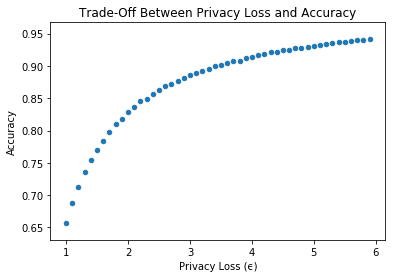

In [7]:
orig_arr = pd.DataFrame(pivot_pa.fillna(0))
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,6.0,.1)
accuracy_df['Privacy Loss (ϵ)'] = eps_range
accuracy_df['Accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('Privacy Loss (ϵ)', 'Accuracy')
plt.title('Trade-Off Between Privacy Loss and Accuracy')
plt.style.use('seaborn-paper')
plt.savefig('out/fig.png',facecolor='w', edgecolor='w',
        orientation='portrait', ransparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

### Postprocessing

Postprocessing the output of a DP mechanism does not degrade privacy. In this case, we want to round any negative counts to zero.

In [8]:
def rounder(x):
    '''
    Rounding helper function
    '''
    if x < 0:
        return 0 
    else:
        return round(x)

In [9]:
#Apply rounder to every cell in new noisy output
noisy_counts = laplace_mech(orig_arr, 3)
rounded_counts = noisy_counts.applymap(rounder)

In [10]:
noisy_counts, rounded_counts

(       No schooling  preschool          K    Grade 1     Grade 2     Grade 3  \
 RAC1P                                                                          
 1       3748.907943  54.008950  48.232236  53.066779   73.352371  230.008151   
 2        632.435362  10.010654  12.448741   8.887868   20.454710   38.674936   
 3         10.482567   0.836671   0.919400  -0.199677    0.937612    2.192477   
 4          0.036330  -0.267501  -0.000071   0.075971    0.178791    0.265819   
 5         10.009972   0.144960  -1.093385   1.810930    4.014598    1.173021   
 6        570.857701   1.638139   3.330490   7.444449   21.104004   31.188156   
 7          3.957572  -0.701023   0.037821  -0.275788   -0.063110    0.678021   
 8        225.245910   2.332382   1.822285  12.562392   13.170322   44.623966   
 9         76.939556   5.086405   1.516858   2.928448    3.999311    8.973780   
 All     5280.727580  72.341106  68.111183  87.991068  137.729232  359.086602   
 
           Grade 4     Gra